# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 170

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 50

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
# scheduler = ExponentialLR(optimizer, gamma=0.95)
scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.1

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/170] :


1 Train: 100%|███████| 391/391 [00:43<00:00,  8.93it/s]

Train Loss: 2.3932 | Train Acc: 13.23%


Test  Loss: 2.1028 | Test Acc: 20.90%
updated best eval loss : 2.1027612731426575
--------------------------------------------------
[Epoch 2/170] :


2 Train: 100%|███████| 391/391 [00:45<00:00,  8.58it/s]


Train Loss: 2.0268 | Train Acc: 23.89%
Test  Loss: 2.0168 | Test Acc: 23.93%
updated best eval loss : 2.016815063319629
--------------------------------------------------
[Epoch 3/170] :


3 Train: 100%|███████| 391/391 [00:46<00:00,  8.46it/s]


Train Loss: 1.6615 | Train Acc: 39.21%
Test  Loss: 2.0925 | Test Acc: 33.68%
--------------------------------------------------
[Epoch 4/170] :


4 Train: 100%|███████| 391/391 [00:35<00:00, 11.03it/s]


Train Loss: 1.2924 | Train Acc: 54.15%
Test  Loss: 1.3787 | Test Acc: 52.33%
updated best eval loss : 1.3787231264235098
--------------------------------------------------
[Epoch 5/170] :


5 Train: 100%|███████| 391/391 [00:34<00:00, 11.24it/s]


Train Loss: 1.0865 | Train Acc: 61.81%
Test  Loss: 1.9567 | Test Acc: 42.03%
--------------------------------------------------
[Epoch 6/170] :


6 Train: 100%|███████| 391/391 [00:33<00:00, 11.62it/s]


Train Loss: 0.9804 | Train Acc: 65.72%
Test  Loss: 1.4186 | Test Acc: 54.76%
--------------------------------------------------
[Epoch 7/170] :


7 Train: 100%|███████| 391/391 [00:32<00:00, 12.21it/s]


Train Loss: 0.9106 | Train Acc: 68.22%
Test  Loss: 1.8498 | Test Acc: 47.38%
--------------------------------------------------
[Epoch 8/170] :


8 Train: 100%|███████| 391/391 [00:32<00:00, 12.00it/s]


Train Loss: 0.8484 | Train Acc: 70.56%
Test  Loss: 0.9311 | Test Acc: 68.36%
updated best eval loss : 0.9310874825791468
--------------------------------------------------
[Epoch 9/170] :


9 Train: 100%|███████| 391/391 [00:34<00:00, 11.25it/s]


Train Loss: 0.8104 | Train Acc: 71.78%
Test  Loss: 1.3588 | Test Acc: 57.01%
--------------------------------------------------
[Epoch 10/170] :


10 Train: 100%|██████| 391/391 [00:33<00:00, 11.65it/s]


Train Loss: 0.7740 | Train Acc: 73.13%
Test  Loss: 1.1262 | Test Acc: 63.70%
--------------------------------------------------
[Epoch 11/170] :


11 Train: 100%|██████| 391/391 [00:33<00:00, 11.85it/s]


Train Loss: 0.7525 | Train Acc: 73.73%
Test  Loss: 1.0131 | Test Acc: 66.52%
--------------------------------------------------
[Epoch 12/170] :


12 Train: 100%|██████| 391/391 [00:33<00:00, 11.78it/s]


Train Loss: 0.7250 | Train Acc: 74.83%
Test  Loss: 1.6305 | Test Acc: 55.28%
--------------------------------------------------
[Epoch 13/170] :


13 Train: 100%|██████| 391/391 [00:33<00:00, 11.83it/s]


Train Loss: 0.7004 | Train Acc: 75.65%
Test  Loss: 1.0730 | Test Acc: 65.78%
--------------------------------------------------
[Epoch 14/170] :


14 Train: 100%|██████| 391/391 [00:35<00:00, 10.91it/s]


Train Loss: 0.6854 | Train Acc: 76.02%
Test  Loss: 0.9337 | Test Acc: 68.77%
--------------------------------------------------
[Epoch 15/170] :


15 Train: 100%|██████| 391/391 [00:48<00:00,  8.08it/s]


Train Loss: 0.6676 | Train Acc: 76.83%
Test  Loss: 0.9890 | Test Acc: 66.95%
--------------------------------------------------
[Epoch 16/170] :


16 Train: 100%|██████| 391/391 [00:45<00:00,  8.67it/s]


Train Loss: 0.6507 | Train Acc: 77.67%
Test  Loss: 1.0316 | Test Acc: 67.76%
--------------------------------------------------
[Epoch 17/170] :


17 Train: 100%|██████| 391/391 [00:48<00:00,  8.08it/s]


Train Loss: 0.6447 | Train Acc: 77.80%
Test  Loss: 0.8529 | Test Acc: 71.45%
updated best eval loss : 0.8529078251198877
--------------------------------------------------
[Epoch 18/170] :


18 Train: 100%|██████| 391/391 [00:46<00:00,  8.48it/s]


Train Loss: 0.6302 | Train Acc: 78.36%
Test  Loss: 0.8800 | Test Acc: 70.95%
--------------------------------------------------
[Epoch 19/170] :


19 Train: 100%|██████| 391/391 [00:47<00:00,  8.21it/s]


Train Loss: 0.6202 | Train Acc: 78.44%
Test  Loss: 0.6774 | Test Acc: 76.98%
updated best eval loss : 0.6774449367311937
--------------------------------------------------
[Epoch 20/170] :


20 Train: 100%|██████| 391/391 [00:46<00:00,  8.41it/s]


Train Loss: 0.6118 | Train Acc: 78.83%
Test  Loss: 0.7915 | Test Acc: 73.51%
--------------------------------------------------
[Epoch 21/170] :


21 Train: 100%|██████| 391/391 [00:47<00:00,  8.18it/s]


Train Loss: 0.6094 | Train Acc: 78.83%
Test  Loss: 1.0809 | Test Acc: 66.44%
--------------------------------------------------
[Epoch 22/170] :


22 Train: 100%|██████| 391/391 [00:46<00:00,  8.46it/s]


Train Loss: 0.5900 | Train Acc: 79.53%
Test  Loss: 0.7649 | Test Acc: 74.03%
--------------------------------------------------
[Epoch 23/170] :


23 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.5834 | Train Acc: 79.84%
Test  Loss: 0.7804 | Test Acc: 72.65%
--------------------------------------------------
[Epoch 24/170] :


24 Train: 100%|██████| 391/391 [00:45<00:00,  8.64it/s]


Train Loss: 0.5844 | Train Acc: 79.73%
Test  Loss: 0.7412 | Test Acc: 75.34%
--------------------------------------------------
[Epoch 25/170] :


25 Train: 100%|██████| 391/391 [00:48<00:00,  8.08it/s]


Train Loss: 0.5712 | Train Acc: 80.10%
Test  Loss: 1.1093 | Test Acc: 65.15%
--------------------------------------------------
[Epoch 26/170] :


26 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.5637 | Train Acc: 80.42%
Test  Loss: 0.8026 | Test Acc: 72.95%
--------------------------------------------------
[Epoch 27/170] :


27 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.5519 | Train Acc: 80.84%
Test  Loss: 0.7889 | Test Acc: 73.54%
--------------------------------------------------
[Epoch 28/170] :


28 Train: 100%|██████| 391/391 [00:46<00:00,  8.49it/s]


Train Loss: 0.5512 | Train Acc: 80.95%
Test  Loss: 0.8902 | Test Acc: 70.70%
--------------------------------------------------
[Epoch 29/170] :


29 Train: 100%|██████| 391/391 [00:48<00:00,  8.06it/s]


Train Loss: 0.5477 | Train Acc: 80.73%
Test  Loss: 0.6763 | Test Acc: 77.00%
updated best eval loss : 0.6762995146497895
--------------------------------------------------
[Epoch 30/170] :


30 Train: 100%|██████| 391/391 [00:46<00:00,  8.48it/s]


Train Loss: 0.5509 | Train Acc: 80.70%
Test  Loss: 1.0020 | Test Acc: 67.09%
--------------------------------------------------
[Epoch 31/170] :


31 Train: 100%|██████| 391/391 [00:47<00:00,  8.19it/s]


Train Loss: 0.5353 | Train Acc: 81.38%
Test  Loss: 0.8557 | Test Acc: 72.00%
--------------------------------------------------
[Epoch 32/170] :


32 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.5322 | Train Acc: 81.47%
Test  Loss: 0.9136 | Test Acc: 70.62%
--------------------------------------------------
[Epoch 33/170] :


33 Train: 100%|██████| 391/391 [00:48<00:00,  8.13it/s]


Train Loss: 0.5332 | Train Acc: 81.42%
Test  Loss: 0.7095 | Test Acc: 75.60%
--------------------------------------------------
[Epoch 34/170] :


34 Train: 100%|██████| 391/391 [00:46<00:00,  8.40it/s]


Train Loss: 0.5252 | Train Acc: 81.60%
Test  Loss: 0.6388 | Test Acc: 78.66%
updated best eval loss : 0.6387961174868331
--------------------------------------------------
[Epoch 35/170] :


35 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.5261 | Train Acc: 81.65%
Test  Loss: 0.8984 | Test Acc: 70.26%
--------------------------------------------------
[Epoch 36/170] :


36 Train: 100%|██████| 391/391 [00:45<00:00,  8.54it/s]


Train Loss: 0.5219 | Train Acc: 81.83%
Test  Loss: 1.2490 | Test Acc: 63.51%
--------------------------------------------------
[Epoch 37/170] :


37 Train: 100%|██████| 391/391 [00:46<00:00,  8.33it/s]


Train Loss: 0.5176 | Train Acc: 82.00%
Test  Loss: 0.9026 | Test Acc: 69.63%
--------------------------------------------------
[Epoch 38/170] :


38 Train: 100%|██████| 391/391 [00:48<00:00,  8.10it/s]


Train Loss: 0.5056 | Train Acc: 82.50%
Test  Loss: 0.6877 | Test Acc: 76.70%
--------------------------------------------------
[Epoch 39/170] :


39 Train: 100%|██████| 391/391 [00:46<00:00,  8.33it/s]


Train Loss: 0.5062 | Train Acc: 82.45%
Test  Loss: 0.9946 | Test Acc: 67.38%
--------------------------------------------------
[Epoch 40/170] :


40 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.4992 | Train Acc: 82.76%
Test  Loss: 0.6751 | Test Acc: 77.25%
--------------------------------------------------
[Epoch 41/170] :


41 Train: 100%|██████| 391/391 [00:45<00:00,  8.55it/s]


Train Loss: 0.5004 | Train Acc: 82.66%
Test  Loss: 0.6854 | Test Acc: 77.05%
--------------------------------------------------
[Epoch 42/170] :


42 Train: 100%|██████| 391/391 [00:45<00:00,  8.57it/s]


Train Loss: 0.4964 | Train Acc: 82.84%
Test  Loss: 0.6407 | Test Acc: 78.44%
--------------------------------------------------
[Epoch 43/170] :


43 Train: 100%|██████| 391/391 [00:47<00:00,  8.22it/s]


Train Loss: 0.4974 | Train Acc: 82.74%
Test  Loss: 0.6835 | Test Acc: 77.30%
--------------------------------------------------
[Epoch 44/170] :


44 Train: 100%|██████| 391/391 [00:47<00:00,  8.27it/s]


Train Loss: 0.4891 | Train Acc: 83.14%
Test  Loss: 0.7062 | Test Acc: 76.15%
--------------------------------------------------
[Epoch 45/170] :


45 Train: 100%|██████| 391/391 [00:45<00:00,  8.55it/s]


Train Loss: 0.4949 | Train Acc: 82.71%
Test  Loss: 0.6451 | Test Acc: 79.28%
--------------------------------------------------
[Epoch 46/170] :


46 Train: 100%|██████| 391/391 [00:46<00:00,  8.38it/s]


Train Loss: 0.4870 | Train Acc: 83.09%
Test  Loss: 0.7247 | Test Acc: 75.11%
--------------------------------------------------
[Epoch 47/170] :


47 Train: 100%|██████| 391/391 [00:46<00:00,  8.49it/s]


Train Loss: 0.4836 | Train Acc: 82.95%
Test  Loss: 0.6046 | Test Acc: 79.59%
updated best eval loss : 0.6045915314668342
--------------------------------------------------
[Epoch 48/170] :


48 Train: 100%|██████| 391/391 [00:47<00:00,  8.16it/s]


Train Loss: 0.4771 | Train Acc: 83.26%
Test  Loss: 0.8418 | Test Acc: 71.55%
--------------------------------------------------
[Epoch 49/170] :


49 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.4762 | Train Acc: 83.36%
Test  Loss: 0.9756 | Test Acc: 70.22%
--------------------------------------------------
[Epoch 50/170] :


50 Train: 100%|██████| 391/391 [00:46<00:00,  8.33it/s]


Train Loss: 0.4757 | Train Acc: 83.42%
Test  Loss: 0.7987 | Test Acc: 73.47%
--------------------------------------------------
[Epoch 51/170] :


51 Train: 100%|██████| 391/391 [00:46<00:00,  8.40it/s]


Train Loss: 0.4790 | Train Acc: 83.22%
Test  Loss: 0.6191 | Test Acc: 80.34%
--------------------------------------------------
[Epoch 52/170] :


52 Train: 100%|██████| 391/391 [00:46<00:00,  8.42it/s]


Train Loss: 0.4712 | Train Acc: 83.37%
Test  Loss: 0.8688 | Test Acc: 72.34%
--------------------------------------------------
[Epoch 53/170] :


53 Train: 100%|██████| 391/391 [00:45<00:00,  8.59it/s]


Train Loss: 0.4681 | Train Acc: 83.66%
Test  Loss: 0.8836 | Test Acc: 72.52%
--------------------------------------------------
[Epoch 54/170] :


54 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.4712 | Train Acc: 83.60%
Test  Loss: 0.8455 | Test Acc: 72.96%
--------------------------------------------------
[Epoch 55/170] :


55 Train: 100%|██████| 391/391 [00:46<00:00,  8.48it/s]


Train Loss: 0.4664 | Train Acc: 83.91%
Test  Loss: 0.6164 | Test Acc: 79.94%
--------------------------------------------------
[Epoch 56/170] :


56 Train: 100%|██████| 391/391 [00:47<00:00,  8.27it/s]


Train Loss: 0.4676 | Train Acc: 83.81%
Test  Loss: 0.6101 | Test Acc: 79.35%
--------------------------------------------------
[Epoch 57/170] :


57 Train: 100%|██████| 391/391 [00:47<00:00,  8.30it/s]


Train Loss: 0.4668 | Train Acc: 83.74%
Test  Loss: 0.6977 | Test Acc: 76.53%
--------------------------------------------------
[Epoch 58/170] :


58 Train: 100%|██████| 391/391 [00:47<00:00,  8.25it/s]


Train Loss: 0.4602 | Train Acc: 84.03%
Test  Loss: 0.6671 | Test Acc: 78.09%
--------------------------------------------------
[Epoch 59/170] :


59 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.4576 | Train Acc: 84.14%
Test  Loss: 0.9443 | Test Acc: 69.12%
--------------------------------------------------
[Epoch 60/170] :


60 Train: 100%|██████| 391/391 [00:46<00:00,  8.49it/s]


Train Loss: 0.4570 | Train Acc: 84.05%
Test  Loss: 0.6514 | Test Acc: 78.04%
--------------------------------------------------
[Epoch 61/170] :


61 Train: 100%|██████| 391/391 [00:46<00:00,  8.38it/s]


Train Loss: 0.4550 | Train Acc: 84.22%
Test  Loss: 0.5572 | Test Acc: 81.69%
updated best eval loss : 0.5571726127704487
--------------------------------------------------
[Epoch 62/170] :


62 Train: 100%|██████| 391/391 [00:46<00:00,  8.46it/s]


Train Loss: 0.4451 | Train Acc: 84.49%
Test  Loss: 0.5351 | Test Acc: 82.20%
updated best eval loss : 0.5351367921014375
--------------------------------------------------
[Epoch 63/170] :


63 Train: 100%|██████| 391/391 [00:47<00:00,  8.29it/s]


Train Loss: 0.4552 | Train Acc: 84.20%
Test  Loss: 1.2369 | Test Acc: 62.59%
--------------------------------------------------
[Epoch 64/170] :


64 Train: 100%|██████| 391/391 [00:46<00:00,  8.45it/s]


Train Loss: 0.4557 | Train Acc: 84.24%
Test  Loss: 0.6596 | Test Acc: 78.69%
--------------------------------------------------
[Epoch 65/170] :


65 Train: 100%|██████| 391/391 [00:47<00:00,  8.20it/s]


Train Loss: 0.4507 | Train Acc: 84.29%
Test  Loss: 0.6632 | Test Acc: 77.87%
--------------------------------------------------
[Epoch 66/170] :


66 Train: 100%|██████| 391/391 [00:46<00:00,  8.35it/s]


Train Loss: 0.4521 | Train Acc: 84.08%
Test  Loss: 0.7032 | Test Acc: 76.90%
--------------------------------------------------
[Epoch 67/170] :


67 Train: 100%|██████| 391/391 [00:48<00:00,  8.14it/s]


Train Loss: 0.4460 | Train Acc: 84.50%
Test  Loss: 0.8410 | Test Acc: 72.69%
--------------------------------------------------
[Epoch 68/170] :


68 Train: 100%|██████| 391/391 [00:45<00:00,  8.54it/s]


Train Loss: 0.4447 | Train Acc: 84.38%
Test  Loss: 0.6715 | Test Acc: 77.20%
--------------------------------------------------
[Epoch 69/170] :


69 Train: 100%|██████| 391/391 [00:47<00:00,  8.19it/s]


Train Loss: 0.4373 | Train Acc: 84.77%
Test  Loss: 0.7803 | Test Acc: 74.49%
--------------------------------------------------
[Epoch 70/170] :


70 Train: 100%|██████| 391/391 [00:46<00:00,  8.49it/s]


Train Loss: 0.4388 | Train Acc: 84.76%
Test  Loss: 0.9450 | Test Acc: 69.53%
--------------------------------------------------
[Epoch 71/170] :


71 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.4383 | Train Acc: 84.70%
Test  Loss: 0.7357 | Test Acc: 76.31%
--------------------------------------------------
[Epoch 72/170] :


72 Train: 100%|██████| 391/391 [00:45<00:00,  8.61it/s]


Train Loss: 0.4386 | Train Acc: 84.77%
Test  Loss: 0.7844 | Test Acc: 74.53%
--------------------------------------------------
[Epoch 73/170] :


73 Train: 100%|██████| 391/391 [00:48<00:00,  8.14it/s]


Train Loss: 0.4356 | Train Acc: 84.91%
Test  Loss: 0.5907 | Test Acc: 80.34%
--------------------------------------------------
[Epoch 74/170] :


74 Train: 100%|██████| 391/391 [00:45<00:00,  8.57it/s]


Train Loss: 0.4389 | Train Acc: 84.81%
Test  Loss: 0.9874 | Test Acc: 67.13%
--------------------------------------------------
[Epoch 75/170] :


75 Train: 100%|██████| 391/391 [00:46<00:00,  8.35it/s]


Train Loss: 0.4292 | Train Acc: 85.18%
Test  Loss: 0.7125 | Test Acc: 75.75%
--------------------------------------------------
[Epoch 76/170] :


76 Train: 100%|██████| 391/391 [00:46<00:00,  8.37it/s]


Train Loss: 0.4318 | Train Acc: 85.03%
Test  Loss: 0.8924 | Test Acc: 72.10%
--------------------------------------------------
[Epoch 77/170] :


77 Train: 100%|██████| 391/391 [00:47<00:00,  8.15it/s]


Train Loss: 0.4309 | Train Acc: 85.07%
Test  Loss: 1.0319 | Test Acc: 69.15%
--------------------------------------------------
[Epoch 78/170] :


78 Train: 100%|██████| 391/391 [00:47<00:00,  8.21it/s]


Train Loss: 0.4301 | Train Acc: 84.87%
Test  Loss: 1.0633 | Test Acc: 66.69%
--------------------------------------------------
[Epoch 79/170] :


79 Train: 100%|██████| 391/391 [00:47<00:00,  8.24it/s]


Train Loss: 0.4261 | Train Acc: 85.22%
Test  Loss: 0.7140 | Test Acc: 75.38%
--------------------------------------------------
[Epoch 80/170] :


80 Train: 100%|██████| 391/391 [00:46<00:00,  8.34it/s]


Train Loss: 0.4338 | Train Acc: 84.86%
Test  Loss: 0.6736 | Test Acc: 77.78%
--------------------------------------------------
[Epoch 81/170] :


81 Train: 100%|██████| 391/391 [00:47<00:00,  8.25it/s]


Train Loss: 0.4290 | Train Acc: 85.41%
Test  Loss: 0.8380 | Test Acc: 73.72%
--------------------------------------------------
[Epoch 82/170] :


82 Train: 100%|██████| 391/391 [00:47<00:00,  8.27it/s]


Train Loss: 0.4205 | Train Acc: 85.35%
Test  Loss: 0.6263 | Test Acc: 79.79%
Learning Rate has changed : Now is 0.010000000000000002
--------------------------------------------------
[Epoch 83/170] :


83 Train: 100%|██████| 391/391 [00:47<00:00,  8.18it/s]


Train Loss: 0.3350 | Train Acc: 88.39%
Test  Loss: 0.4631 | Test Acc: 84.04%
updated best eval loss : 0.46312285186369206
--------------------------------------------------
[Epoch 84/170] :


84 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.2999 | Train Acc: 89.57%
Test  Loss: 0.4966 | Test Acc: 82.90%
--------------------------------------------------
[Epoch 85/170] :


85 Train: 100%|██████| 391/391 [00:47<00:00,  8.15it/s]


Train Loss: 0.2914 | Train Acc: 89.85%
Test  Loss: 0.5402 | Test Acc: 81.54%
--------------------------------------------------
[Epoch 86/170] :


86 Train: 100%|██████| 391/391 [00:47<00:00,  8.25it/s]


Train Loss: 0.2817 | Train Acc: 90.02%
Test  Loss: 0.5107 | Test Acc: 82.61%
--------------------------------------------------
[Epoch 87/170] :


87 Train: 100%|██████| 391/391 [00:46<00:00,  8.39it/s]


Train Loss: 0.2748 | Train Acc: 90.39%
Test  Loss: 0.5155 | Test Acc: 82.99%
--------------------------------------------------
[Epoch 88/170] :


88 Train: 100%|██████| 391/391 [00:48<00:00,  8.08it/s]


Train Loss: 0.2686 | Train Acc: 90.54%
Test  Loss: 0.4867 | Test Acc: 83.68%
--------------------------------------------------
[Epoch 89/170] :


89 Train: 100%|██████| 391/391 [00:46<00:00,  8.36it/s]


Train Loss: 0.2628 | Train Acc: 90.77%
Test  Loss: 0.5322 | Test Acc: 82.02%
--------------------------------------------------
[Epoch 90/170] :


90 Train: 100%|██████| 391/391 [00:47<00:00,  8.25it/s]


Train Loss: 0.2580 | Train Acc: 90.95%
Test  Loss: 0.5244 | Test Acc: 82.53%
--------------------------------------------------
[Epoch 91/170] :


91 Train: 100%|██████| 391/391 [00:46<00:00,  8.44it/s]


Train Loss: 0.2554 | Train Acc: 91.12%
Test  Loss: 0.4764 | Test Acc: 84.27%
--------------------------------------------------
[Epoch 92/170] :


92 Train: 100%|██████| 391/391 [00:45<00:00,  8.53it/s]


Train Loss: 0.2588 | Train Acc: 90.99%
Test  Loss: 0.5905 | Test Acc: 80.14%
--------------------------------------------------
[Epoch 93/170] :


93 Train: 100%|██████| 391/391 [00:38<00:00, 10.14it/s]


Train Loss: 0.2564 | Train Acc: 91.11%
Test  Loss: 0.5608 | Test Acc: 81.65%
--------------------------------------------------
[Epoch 94/170] :


94 Train: 100%|██████| 391/391 [00:38<00:00, 10.03it/s]


Train Loss: 0.2474 | Train Acc: 91.34%
Test  Loss: 0.5239 | Test Acc: 82.69%
--------------------------------------------------
[Epoch 95/170] :


95 Train: 100%|██████| 391/391 [00:32<00:00, 12.05it/s]


Train Loss: 0.2515 | Train Acc: 91.21%
Test  Loss: 0.5489 | Test Acc: 81.68%
--------------------------------------------------
[Epoch 96/170] :


96 Train: 100%|██████| 391/391 [00:21<00:00, 18.31it/s]


Train Loss: 0.2448 | Train Acc: 91.43%
Test  Loss: 0.5649 | Test Acc: 81.40%
--------------------------------------------------
[Epoch 97/170] :


97 Train: 100%|██████| 391/391 [00:19<00:00, 19.93it/s]


Train Loss: 0.2450 | Train Acc: 91.44%
Test  Loss: 0.5251 | Test Acc: 82.71%
--------------------------------------------------
[Epoch 98/170] :


98 Train: 100%|██████| 391/391 [00:18<00:00, 20.95it/s]


Train Loss: 0.2446 | Train Acc: 91.37%
Test  Loss: 0.5707 | Test Acc: 81.08%
--------------------------------------------------
[Epoch 99/170] :


99 Train: 100%|██████| 391/391 [00:18<00:00, 20.84it/s]


Train Loss: 0.2415 | Train Acc: 91.64%
Test  Loss: 0.6404 | Test Acc: 79.09%
--------------------------------------------------
[Epoch 100/170] :


100 Train: 100%|█████| 391/391 [00:14<00:00, 26.73it/s]


Train Loss: 0.2375 | Train Acc: 91.69%
Test  Loss: 0.5819 | Test Acc: 81.39%
--------------------------------------------------
[Epoch 101/170] :


101 Train: 100%|█████| 391/391 [00:13<00:00, 28.69it/s]


Train Loss: 0.2350 | Train Acc: 91.89%
Test  Loss: 0.5929 | Test Acc: 80.67%
--------------------------------------------------
[Epoch 102/170] :


102 Train: 100%|█████| 391/391 [00:14<00:00, 27.05it/s]


Train Loss: 0.2344 | Train Acc: 91.83%
Test  Loss: 0.5929 | Test Acc: 80.79%
--------------------------------------------------
[Epoch 103/170] :


103 Train: 100%|█████| 391/391 [00:15<00:00, 25.95it/s]


Train Loss: 0.2348 | Train Acc: 91.94%
Test  Loss: 0.6313 | Test Acc: 79.65%
--------------------------------------------------
[Epoch 104/170] :


104 Train: 100%|█████| 391/391 [00:13<00:00, 28.05it/s]


Train Loss: 0.2351 | Train Acc: 91.86%
Test  Loss: 0.7099 | Test Acc: 76.86%
--------------------------------------------------
[Epoch 105/170] :


105 Train: 100%|█████| 391/391 [00:14<00:00, 26.60it/s]


Train Loss: 0.2337 | Train Acc: 91.87%
Test  Loss: 0.6012 | Test Acc: 80.60%
--------------------------------------------------
[Epoch 106/170] :


106 Train: 100%|█████| 391/391 [00:14<00:00, 26.52it/s]


Train Loss: 0.2256 | Train Acc: 92.17%
Test  Loss: 0.5930 | Test Acc: 80.86%
--------------------------------------------------
[Epoch 107/170] :


107 Train: 100%|█████| 391/391 [00:14<00:00, 27.14it/s]


Train Loss: 0.2308 | Train Acc: 92.01%
Test  Loss: 0.6933 | Test Acc: 77.70%
--------------------------------------------------
[Epoch 108/170] :


108 Train: 100%|█████| 391/391 [00:13<00:00, 28.39it/s]


Train Loss: 0.2324 | Train Acc: 91.98%
Test  Loss: 0.6478 | Test Acc: 79.26%
--------------------------------------------------
[Epoch 109/170] :


109 Train: 100%|█████| 391/391 [00:14<00:00, 26.51it/s]


Train Loss: 0.2290 | Train Acc: 91.94%
Test  Loss: 0.6491 | Test Acc: 78.92%
--------------------------------------------------
[Epoch 110/170] :


110 Train: 100%|█████| 391/391 [00:14<00:00, 26.15it/s]


Train Loss: 0.2235 | Train Acc: 92.16%
Test  Loss: 0.5553 | Test Acc: 81.87%
--------------------------------------------------
[Epoch 111/170] :


111 Train: 100%|█████| 391/391 [00:13<00:00, 28.86it/s]


Train Loss: 0.2244 | Train Acc: 92.29%
Test  Loss: 0.6528 | Test Acc: 79.35%
--------------------------------------------------
[Epoch 112/170] :


112 Train: 100%|█████| 391/391 [00:14<00:00, 26.34it/s]


Train Loss: 0.2242 | Train Acc: 92.12%
Test  Loss: 0.6657 | Test Acc: 78.40%
--------------------------------------------------
[Epoch 113/170] :


113 Train: 100%|█████| 391/391 [00:14<00:00, 26.95it/s]


Train Loss: 0.2235 | Train Acc: 92.26%
Test  Loss: 0.6199 | Test Acc: 79.94%
--------------------------------------------------
[Epoch 114/170] :


114 Train: 100%|█████| 391/391 [00:13<00:00, 28.30it/s]


Train Loss: 0.2218 | Train Acc: 92.16%
Test  Loss: 0.6218 | Test Acc: 80.33%
--------------------------------------------------
[Epoch 115/170] :


115 Train: 100%|█████| 391/391 [00:14<00:00, 27.92it/s]


Train Loss: 0.2250 | Train Acc: 92.23%
Test  Loss: 0.6932 | Test Acc: 78.87%
--------------------------------------------------
[Epoch 116/170] :


116 Train: 100%|█████| 391/391 [00:15<00:00, 25.89it/s]


Train Loss: 0.2212 | Train Acc: 92.23%
Test  Loss: 0.6349 | Test Acc: 80.10%
--------------------------------------------------
[Epoch 117/170] :


117 Train: 100%|█████| 391/391 [00:14<00:00, 26.84it/s]


Train Loss: 0.2255 | Train Acc: 92.10%
Test  Loss: 0.6067 | Test Acc: 81.21%
--------------------------------------------------
[Epoch 118/170] :


118 Train: 100%|█████| 391/391 [00:14<00:00, 27.55it/s]


Train Loss: 0.2185 | Train Acc: 92.46%
Test  Loss: 0.6951 | Test Acc: 78.73%
--------------------------------------------------
[Epoch 119/170] :


119 Train: 100%|█████| 391/391 [00:13<00:00, 28.50it/s]


Train Loss: 0.2172 | Train Acc: 92.45%
Test  Loss: 0.7886 | Test Acc: 75.73%
--------------------------------------------------
[Epoch 120/170] :


120 Train: 100%|█████| 391/391 [00:14<00:00, 26.94it/s]


Train Loss: 0.2238 | Train Acc: 92.07%
Test  Loss: 0.6616 | Test Acc: 79.63%
--------------------------------------------------
[Epoch 121/170] :


121 Train: 100%|█████| 391/391 [00:13<00:00, 28.22it/s]


Train Loss: 0.2170 | Train Acc: 92.46%
Test  Loss: 0.6096 | Test Acc: 81.23%
--------------------------------------------------
[Epoch 122/170] :


122 Train: 100%|█████| 391/391 [00:15<00:00, 25.59it/s]


Train Loss: 0.2162 | Train Acc: 92.55%
Test  Loss: 0.6208 | Test Acc: 80.19%
--------------------------------------------------
[Epoch 123/170] :


123 Train: 100%|█████| 391/391 [00:14<00:00, 26.82it/s]


Train Loss: 0.2127 | Train Acc: 92.52%
Test  Loss: 0.5621 | Test Acc: 82.41%
Learning Rate has changed : Now is 0.0010000000000000002
--------------------------------------------------
[Epoch 124/170] :


124 Train: 100%|█████| 391/391 [00:13<00:00, 28.70it/s]


Train Loss: 0.2031 | Train Acc: 92.93%
Test  Loss: 0.5742 | Test Acc: 81.77%
--------------------------------------------------
[Epoch 125/170] :


125 Train: 100%|█████| 391/391 [00:14<00:00, 27.78it/s]


Train Loss: 0.1974 | Train Acc: 93.13%
Test  Loss: 0.5805 | Test Acc: 81.34%
--------------------------------------------------
[Epoch 126/170] :


126 Train: 100%|█████| 391/391 [00:14<00:00, 26.44it/s]


Train Loss: 0.1980 | Train Acc: 93.22%
Test  Loss: 0.6032 | Test Acc: 81.14%
--------------------------------------------------
[Epoch 127/170] :


127 Train: 100%|█████| 391/391 [00:13<00:00, 28.57it/s]


Train Loss: 0.1956 | Train Acc: 93.31%
Test  Loss: 0.5833 | Test Acc: 81.55%
--------------------------------------------------
[Epoch 128/170] :


128 Train: 100%|█████| 391/391 [00:14<00:00, 26.84it/s]


Train Loss: 0.1967 | Train Acc: 93.16%
Test  Loss: 0.5944 | Test Acc: 80.99%
--------------------------------------------------
[Epoch 129/170] :


129 Train: 100%|█████| 391/391 [00:15<00:00, 25.79it/s]


Train Loss: 0.1914 | Train Acc: 93.43%
Test  Loss: 0.5897 | Test Acc: 81.45%
--------------------------------------------------
[Epoch 130/170] :


130 Train: 100%|█████| 391/391 [00:14<00:00, 27.90it/s]


Train Loss: 0.1929 | Train Acc: 93.34%
Test  Loss: 0.6071 | Test Acc: 81.17%
--------------------------------------------------
[Epoch 131/170] :


131 Train: 100%|█████| 391/391 [00:14<00:00, 26.81it/s]


Train Loss: 0.1966 | Train Acc: 93.19%
Test  Loss: 0.6099 | Test Acc: 80.65%
--------------------------------------------------
[Epoch 132/170] :


132 Train: 100%|█████| 391/391 [00:15<00:00, 25.93it/s]


Train Loss: 0.1941 | Train Acc: 93.29%
Test  Loss: 0.6264 | Test Acc: 80.27%
--------------------------------------------------
[Epoch 133/170] :


133 Train: 100%|█████| 391/391 [00:14<00:00, 26.45it/s]


Train Loss: 0.1918 | Train Acc: 93.44%
Test  Loss: 0.6181 | Test Acc: 80.39%
Early stop!! best_eval_loss = 0.46312285186369206


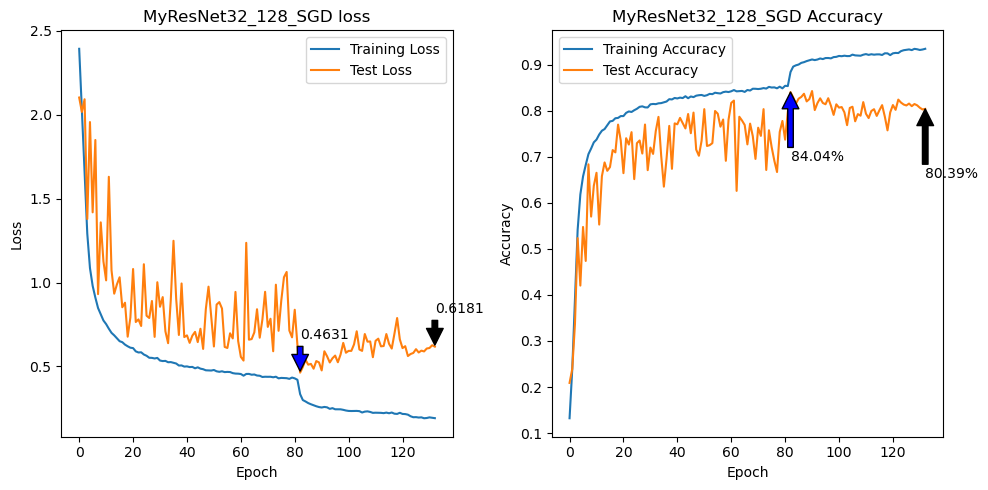

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=2.3932, train_acc=0.1323, test_loss=2.1028, test_acc=0.2090, lr=0.1000
2 epoch: train_loss=2.0268, train_acc=0.2389, test_loss=2.0168, test_acc=0.2393, lr=0.1000
3 epoch: train_loss=1.6615, train_acc=0.3921, test_loss=2.0925, test_acc=0.3368, lr=0.1000
4 epoch: train_loss=1.2924, train_acc=0.5415, test_loss=1.3787, test_acc=0.5233, lr=0.1000
5 epoch: train_loss=1.0865, train_acc=0.6181, test_loss=1.9567, test_acc=0.4203, lr=0.1000
6 epoch: train_loss=0.9804, train_acc=0.6572, test_loss=1.4186, test_acc=0.5476, lr=0.1000
7 epoch: train_loss=0.9106, train_acc=0.6822, test_loss=1.8498, test_acc=0.4738, lr=0.1000
8 epoch: train_loss=0.8484, train_acc=0.7056, test_loss=0.9311, test_acc=0.6836, lr=0.1000
9 epoch: train_loss=0.8104, train_acc=0.7178, test_loss=1.3588, test_acc=0.5701, lr=0.1000
10 epoch: train_loss=0.7740, train_acc=0.7313, test_loss=1.1262, test_acc=0.6370, lr=0.1000
11 epoch: train_loss=0.7525, train_acc=0.7373, test_loss=1.0131, test_acc=0.6652, lr=0.10